This notebook explains the basics of a neural network. We start from creating a class `Value` that represents scalar numbers. It acts as a part of an expression and stores the links to other `Value` objects from which the value was derived. This article also looks at how back propragation works in a neural network and implements a basic one in the `Value` class.

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# A quadratic equation 
def f(x):
    return 4*x**2 - 3*x - 10

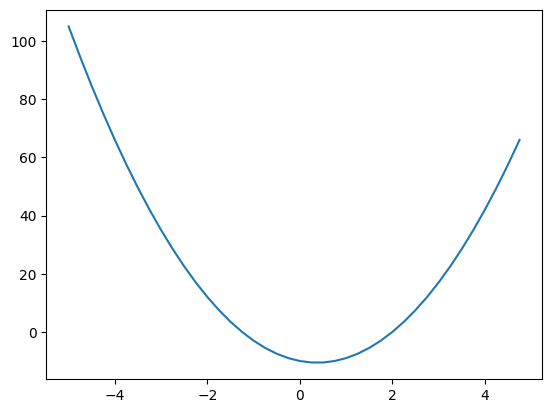

In [9]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

A derivative is an expression that defines the rate at which a function changes with respect to another variable.
dy/dx represents the amount by which y changes when there is a unit change in x. 

A representation of derivative of a variable x wrt function f(x):

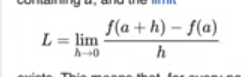


In [16]:
h=0.00000001
x=1
dy_by_dx = (f(x+h)-f(x))/h

dy_by_dx

5.000000058430487

In [3]:
# A simple implementation of the Value class
class Value:
    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        # the values on which this value depends on
        self._prev = set(_children)
        # operator used to obtain this value
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    # overloading operators
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

In [2]:
# draw expression graph
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_root(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})    # LR => left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f}" % (n.label, n.data), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid+n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

In [20]:
# A simple expression graph

a = Value(1, label='a')
b = Value(3, label='b')
c = Value(2, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-5, label='f')
L = d*f; L.label = 'L'
L

Value(data=-25)

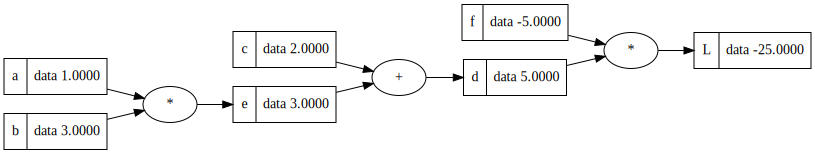

In [21]:
draw_root(L)

In [17]:
def lol():
    h = 0.0001
    a = Value(1, label="a")
    b = Value(3, label="b")
    c = Value(2, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-5, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data

    a = Value(1, label="a")
    b = Value(3, label="b")
    c = Value(2, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-5+h, label="f")

    L2 = (d * f).data

    print("Slope: ", (L2 - L1) / h)

lol()

Slope:  4.999999999988347


A simple neuron

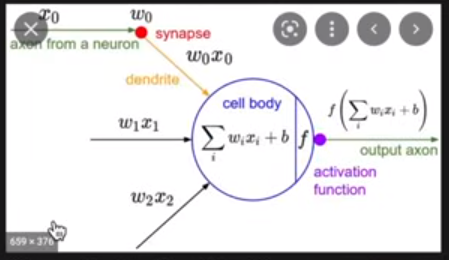

Let's try to recreate this using the Value class

In [25]:
# Inputs
x1 = Value(1.0, label="x1")
x2 = Value(2.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(5, label="w2")

# bias
b = Value(3.2, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
n

Value(data=10.2)

We need one more operator in our Value class for the activation function. This tutorial would be using tanh function.

In [26]:
# The updated Value class
class Value:
    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        # the values on which this value depends on
        self._prev = set(_children)
        # operator used to obtain this value
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    # overloading operators
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1)/ (math.exp(2*n)+1)
        out = Value(t, _children=(self,), _op="tanh")
        return out

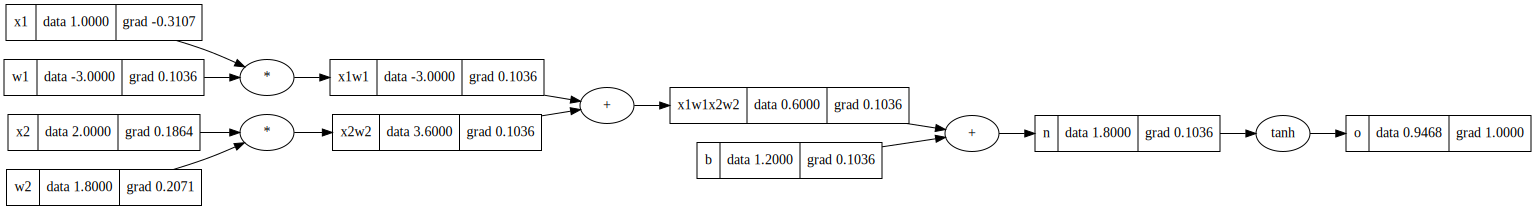

In [48]:
# Inputs
x1 = Value(1.0, label="x1")
x2 = Value(2.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.8, label="w2")

# bias
b = Value(1.2, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.grad = 1
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_root(o)

Now we need to upate the draw_root function to display the gradients along with the data and the Value class to calculate the gradients as we evaluate the expressions.

In [36]:
# updated draw root function
def draw_root(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})    # LR => left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid+n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

In [47]:
# The updated Value class
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        # the values on which this value depends on
        self._prev = set(_children)
        # operator used to obtain this value
        self._op = _op
        self.label = label
        # default gradient is zero, it will be calculated when self._backward is called
        self.grad = 0
        # _backward calculates the gradient of its dependencies
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    # overloading operators
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # chain rule => self.grad = (derivative of out wrt self)*(derivative of the final value wrt out)
            self.grad = out.grad * 1
            other.grad = out.grad * 1

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out

Now calculate the gradients one by one from the root

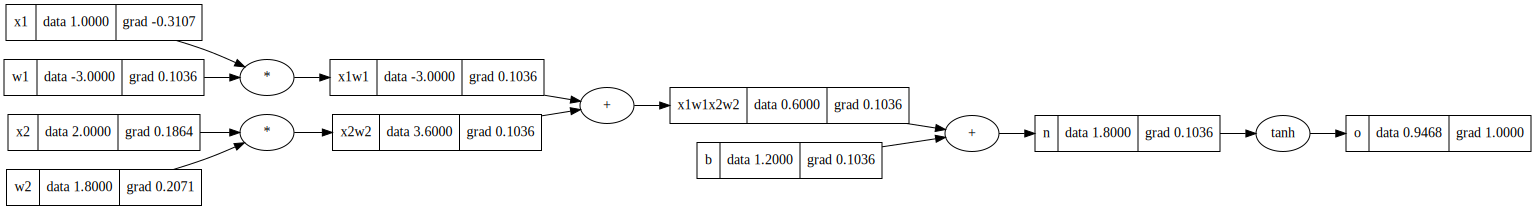

In [49]:
# Inputs
x1 = Value(1.0, label="x1")
x2 = Value(2.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.8, label="w2")

# bias
b = Value(1.2, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.grad = 1 # you need to set the base case
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_root(o)

Now let's implement another method in the Value class to calculate gradients in a topological sort order

In [58]:
# The updated Value class
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        # the values on which this value depends on
        self._prev = set(_children)
        # operator used to obtain this value
        self._op = _op
        self.label = label
        # default gradient is zero, it will be calculated when self._backward is called
        self.grad = 0
        # _backward calculates the gradient of its dependencies
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    # overloading operators
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # chain rule => self.grad = (derivative of out wrt self)*(derivative of the final value wrt out)
            self.grad = out.grad * 1
            other.grad = out.grad * 1

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    # calculate the gradients of all dependencies in a topologically sorted order
    def backward(self):
        topo=[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        print(topo)

        for node in reversed(topo):
            node._backward()

[Value(data=1.2), Value(data=1.0), Value(data=-3.0), Value(data=-3.0), Value(data=2.0), Value(data=1.8), Value(data=3.6), Value(data=0.6000000000000001), Value(data=1.8), Value(data=0.9468060128462683)]


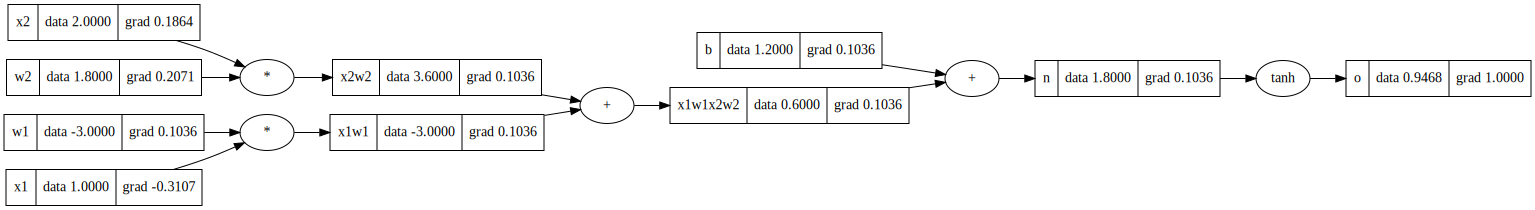

In [62]:
# Inputs
x1 = Value(1.0, label="x1")
x2 = Value(2.0, label="x2")

# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.8, label="w2")

# bias
b = Value(1.2, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

o.grad = 1  # you need to set the base case
o.backward()
draw_root(o)

But there is one problem. Below code does not produce the desired results.
In the equation, d1 = a1*b1 the gradients are set once.
In the equation, e1 = a1*b1 the gradients are set again instead the new gradients should be added.

[Value(data=-3.0), Value(data=2), Value(data=-6.0), Value(data=-6.0), Value(data=36.0)]


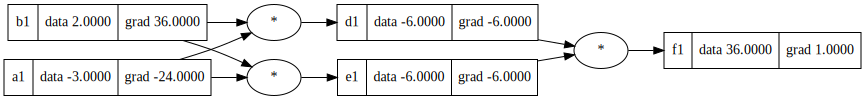

In [66]:
a1 = Value(-3.0, label="a1")
b1 = Value(2, label="b1")
d1 = a1 * b1
d1.label = "d1"
e1 = a1 * b1
e1.label = "e1"
f1 = d1 * e1
f1.label = "f1"

f1.grad = 1
f1.backward()
draw_root(f1)

In [65]:
# The updated Value class
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        # the values on which this value depends on
        self._prev = set(_children)
        # operator used to obtain this value
        self._op = _op
        self.label = label
        # default gradient is zero, it will be calculated when self._backward is called
        self.grad = 0
        # _backward calculates the gradient of its dependencies
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    # overloading operators
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # THIS IS THE BUG
            # chain rule => self.grad = (derivative of out wrt self)*(derivative of the final value wrt out)
            # self.grad = out.grad * 1
            # other.grad = out.grad * 1
            self.grad += out.grad * 1
            other.grad += out.grad * 1
            

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    # calculate the gradients of all dependencies in a topologically sorted order
    def backward(self):
        topo=[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        print(topo)

        for node in reversed(topo):
            node._backward()

Now the results are correct.

[Value(data=-3.0), Value(data=2), Value(data=-6.0), Value(data=-6.0), Value(data=36.0)]


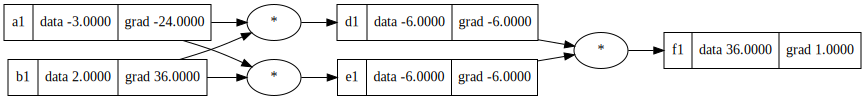

In [67]:
a1 = Value(-3.0, label="a1")
b1 = Value(2, label="b1")
d1 = a1 * b1
d1.label = "d1"
e1 = a1 * b1
e1.label = "e1"
f1 = d1 * e1
f1.label = "f1"

f1.grad = 1
f1.backward()
draw_root(f1)

Our Value class does not support operations with constants
Example, a + 1
Lets fix that

In [78]:
# The updated Value class
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        # the values on which this value depends on
        self._prev = set(_children)
        # operator used to obtain this value
        self._op = _op
        self.label = label
        # default gradient is zero, it will be calculated when self._backward is called
        self.grad = 0
        # _backward calculates the gradient of its dependencies
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    # overloading operators
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # THIS IS THE BUG
            # chain rule => self.grad = (derivative of out wrt self)*(derivative of the final value wrt out)
            # self.grad = out.grad * 1
            # other.grad = out.grad * 1
            self.grad += out.grad * 1
            other.grad += out.grad * 1
            

        out._backward = _backward
        return out

    # handles 2 + Value(1) => other + self
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    # handles 2 * Value(1) => other*self
    def __rmul__(self, other): 
        return self*other

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    # calculate the gradients of all dependencies in a topologically sorted order
    def backward(self):
        topo=[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        print(topo)

        for node in reversed(topo):
            node._backward()

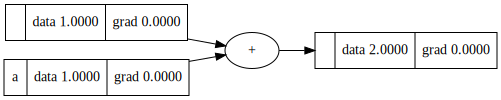

In [80]:
a = Value(1, label="a")
b = 1+a

draw_root(b)